# <center> Earth to Venus Transfer Using Patched Conics Approach </center> 
<center> AERO 557 - Advanced Orbital Mechanics | Spring 2025 | Madhusudan Vijayakumar </center> 

**Objective:** \
From this example, we shall demonstrate how to compute an interplanetary trajectory using the patched conic approach.

**Dynamic Model:** \
We will model the orbital dynamics using a two-body model.  

**Trajectory Design:** \
The trajectory design is divided into three phases:
1. **Heliocentric Phase :** Sun is the central body. We model the transfers trajectory between the edge of spheres of influence of the Earth and the Venus.
2. **Departure Phase :** Earth is the central body. We model the transfer from parking orbit to the edge of sphere of influence as an outgoing hyperbolic trajectory.
3. **Arrival Phase :** Venus is the central body. We model the transfer from the edge of sphere of influence to the target orbit as an incoming hyperbolic trajectory. 

In [1]:
# Import required libraries
import os
import sys
import numpy as np
from math import radians, sqrt 
from jplephem.spk import SPK
from jplephem.calendar import compute_julian_date
from lambert import LambertIzzo
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

# Extract Ephemeris
ephem = SPK.open("de430.bsp")

**Two-Body Propagator Function**

In [2]:
def two_body_propagator(t, y, mu):
    """
    Computes the time derivative of the state vector y for the two-body problem.
    
    Parameters:
      t  (float)    : Time 
      y  (ndarray)  : state vector [r_x, r_y, r_z, v_x, v_y, v_z].
      mu (float)    : gravitational parameter
    
    Returns:
      dydt (ndarray) : The time derivative [v, a].
    """
    r = y[:3]
    v = y[3:]
    a = -mu * r / np.linalg.norm(r)**3
    return np.concatenate((v, a))

**Setup Problem Parameters:**

In [3]:
# Constants
rE = 6378.18        # Earth Radius [km]
rV = 6051.8         # Radius of Venus [km]
muE = 398600        # Grav Parameter of Earth [km3/s2]
muV = 324860        # Grav Parameter of Venus [km3/s2]
muS = 1.32712e11    # Grav Paremeter of Sun [km3/s2]
earth = ephem[0,3]  # Extracts Earth Ephem wrt SolarSystem Barycenter
venus = ephem[0,2]  # Extracts Venus Ephem wrt SolarSystem Barycenter

# Dates
launchDate  = compute_julian_date(2025, 1, 1) # launch Date
arrivalDate = compute_julian_date(2025, 4, 1) # arrival Date
tof = arrivalDate - launchDate  # Time of Flight
nrev = 0

# parking orbit
hParking = 400                         # Altitude of parking orbit around Earth (km)
rParking = rE+hParking
vParking = sqrt(muE/rParking)

# target orbit
hTarget = 400                          # Altitude of target orbit around Venus (km)
rTarget = rV+hTarget
vTarget = sqrt(muV/rTarget)

**Get Earth and Venus states on departure and arrival**

In [4]:
rEarth, vEarth = earth.compute_and_differentiate(launchDate)
rVenus, vVenus = venus.compute_and_differentiate(arrivalDate)
vEarth = vEarth/86400       # [km/s]
vVenus = vVenus/86400       # [km/s]

**Heliocentric Phase:**

In [5]:
vSatDept, vSatArv, exitflag = LambertIzzo(muS, np.array(rEarth), np.array(rVenus), tof, nrev)

**Departure Phase**

In [6]:
# Calculate departure V-infinity (velocity of the s/c wrt Earth)
vInfDept = np.linalg.norm(vSatDept - vEarth)

# Velocity on Departure Hyperbola (with a perigee radius of parking orbit)
vHypPeriDept = sqrt(2*muE/rParking + vInfDept**2)

# Departure Delta-v (difference between parking orbit and hyperbola velocity)
delV1 = vHypPeriDept - vParking

**Arrival Phase:**

In [7]:
# Calculate arrival V-infinity (velocity of the s/c wrt Venus)
vInfArv = np.linalg.norm(vSatArv - vVenus)

# Velocity on Departure Hyperbola (with a perigee radius of parking orbit)
vHypPeriArv = sqrt(2*muV/rTarget + vInfArv**2)

# Capture Delta-v (difference between parking orbit and hyperbola velocity)
delV2 = vHypPeriArv - vTarget

**Total Delta-V**

In [8]:
totDelV = delV1+delV2
print(totDelV)

11.213212141271445


**Create Transfer Orbit**

In [9]:
# Integration Tolerance
rtol, atol = 1e-8, 1e-9

# Earth's orbit: propagate for 365 days
statesEarth = solve_ivp(lambda t, y: two_body_propagator(t, y, muS),
                      (0, 365*86400), np.hstack((rEarth, vEarth)), rtol=rtol, atol=atol)

# Venus' orbit: propagate for 230 days
statesVenus = solve_ivp(lambda t, y: two_body_propagator(t, y, muS),
                      (0, 230*86400), np.hstack((rVenus, vVenus)), rtol=rtol, atol=atol)

# Transfer orbit: propagate for tof seconds (time of flight)
statesTrans = solve_ivp(lambda t, y: two_body_propagator(t, y, muS),
                      (0, tof*86400), np.hstack((rEarth, vSatDept)), rtol=rtol, atol=atol)

**Plot Trajectory**

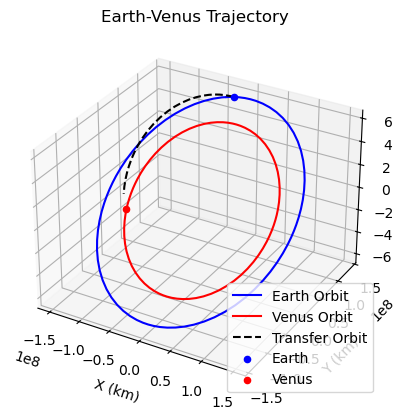

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Convert positions from meters to kilometers for plotting.
ax.plot(statesEarth.y[0], statesEarth.y[1], statesEarth.y[2], 'b-', label='Earth Orbit')
ax.plot(statesVenus.y[0], statesVenus.y[1], statesVenus.y[2], 'r-', label='Venus Orbit')
ax.plot(statesTrans.y[0], statesTrans.y[1], statesTrans.y[2], 'k--', label='Transfer Orbit')

# Mark the initial positions
ax.scatter(statesEarth.y[0,0], statesEarth.y[1,0], statesEarth.y[2,0], color='b', marker='o', label='Earth')
ax.scatter(statesVenus.y[0,0], statesVenus.y[1,0], statesVenus.y[2,0], color='r', marker='o', label='Venus')

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title('Earth-Venus Trajectory')
ax.legend()
ax.grid(True)
plt.show()

**How does Departure V_infinity affect the delta-v at departure**

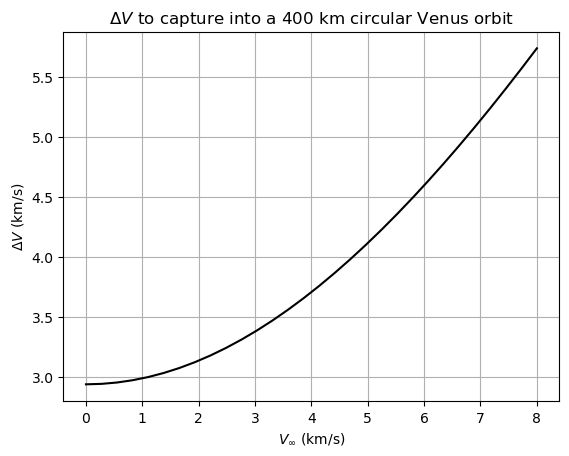

In [11]:
# Create a list of arrival V_infinity values (km/s)
vInfArvList = np.linspace(0, 8, 30)  # in km/s
delVArv = np.zeros(len(vInfArvList))

for i, vInfArv in enumerate(vInfArvList):

    # Velocity on Departure Hyperbola
    vHypPeriArv = np.sqrt(2*muV/rTarget + (vInfArv)**2)

    # Arrival Delta-v 
    delVArv[i] = (vHypPeriArv - vTarget)   

plt.figure()
plt.plot(vInfArvList, delVArv, 'k-')
plt.grid(True)
plt.xlabel('$V_{\\infty}$ (km/s)')
plt.ylabel('$\\Delta V$ (km/s)')
plt.title('$\\Delta V$ to capture into a 400 km circular Venus orbit')
plt.show()

**How does Departure orbit altitude affect the departure delta-v**

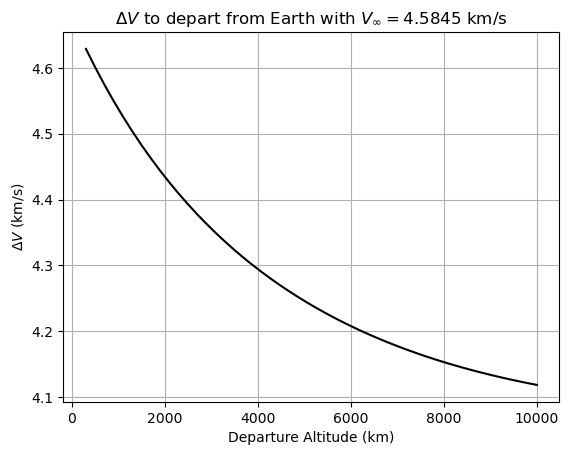

In [13]:
# Departure Orbit radius
deptAltitudeList = np.linspace(300, 10000, 50)  # km
delVDept = np.zeros(len(deptAltitudeList))

for i, alt in enumerate(deptAltitudeList):

    # Velocity of the orbit 
    rParking = rE + alt
    vParking = np.sqrt(muE / rParking)

    # Velocity on Departure Hyperbola (with a perigee radius of parking orbit)
    vHypPeriDept = np.sqrt(2*muE/rParking + vInfDept**2)

    # Departure Delta-v (difference between parking orbit and hyperbola velocity)
    delVDept[i] = (vHypPeriDept - vParking)

# Plot
plt.figure()
plt.plot(deptAltitudeList, delVDept, 'k-')
plt.grid(True)
plt.xlabel('Departure Altitude (km)')
plt.ylabel('$\\Delta V$ (km/s)')
plt.title('$\\Delta V$ to depart from Earth with $V_{\\infty} = 4.5845$ km/s')
plt.show()